# Configuración Inicial

In [1]:
# Importar paquetes
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
from shapely import wkt
import statistics
import matplotlib.pyplot as plt
import zipfile

import os

# Import paquetes con los modelos de sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Importar métricas
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, 
                             explained_variance_score as evs, r2_score as r2)                
from sklearn.metrics import (accuracy_score as acc, balanced_accuracy_score as bal_acc, 
                             f1_score as f1, roc_auc_score as roc_auc,
                             average_precision_score as ave_prec)                            
def mape(Y_actual,Y_Predicted):
    #print(Y_actual, Y_Predicted)
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

r_state = 42

ruta2 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Variables\Procesados\Secciones2"

# Importar dataframes y crear conjuntos train y test

## Importar dataframes

In [5]:
path_2011 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Variables\Procesados\Secciones2\df_2011.csv"
path_2021 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Variables\Procesados\Secciones2\df_2021.csv"
df_2011 = pd.read_csv(path_2011, sep=";")
df_2021 = pd.read_csv(path_2021, sep=";")

df_2011.rename(columns={'SES_11': 'SES', 'he_pct_11': 'he_pct', 'kw_pct_11': 'kw_pct', 'median_price_inf_11': 'median_price_inf','RANK_11':'RANK','SES_PR_11':'SES_PR'}, inplace=True)
df_2021.rename(columns={'SES_21': 'SES', 'he_pct_21': 'he_pct', 'kw_pct_21': 'kw_pct', 'median_price_inf_21': 'median_price_inf','RANK_21':'RANK','SES_PR_21':'SES_PR'}, inplace=True)

#print(df_2011)
#print(df_2021)

## Conjunto train y test

In [8]:
# Se dividen los conjuntos usando 80/20 respectivamente
train, test = train_test_split(df_2011, test_size = 0.2, random_state = r_state)

x_train = train.loc[:, ~train.columns.isin(["SES","he_pct","kw_pct","median_price_inf","RANK","SES_PR"])]
y_train = train.loc[:, train.columns == 'SES'].values.ravel()

x_test = test.loc[:, ~test.columns.isin(["SES","he_pct","kw_pct","median_price_inf","RANK","SES_PR"])]
y_test = test.loc[:, test.columns == 'SES'].values.ravel()

#print(x_train)
#print(y_train)
#print(x_test)
#print(y_test)

# Construir RF

In [11]:
# Crear Modelo
rf = RandomForestRegressor(random_state=r_state)

In [13]:
# Entrenar modelo
rf_model = rf.fit(x_train, y_train)

# Predecir conjunto test con el modelo
y_pred_rf = rf_model.predict(x_test)

In [14]:
# Calcular métricas de desempeño
mae_rf = mae(y_test, y_pred_rf)
mse_rf = mse(y_test, y_pred_rf)
evs_rf = evs(y_test, y_pred_rf)
r2_rf = r2(y_test, y_pred_rf)
mape_rf = mape(y_test, y_pred_rf)

print(f"mae_rf: {mae_rf}, \nmse_rf: {mse_rf}, \nevs_rf: {evs_rf}, \nr2_rf: {r2_rf}, \nmape_rf: {mape_rf}")

mae_rf: 0.18097718165757423, 
mse_rf: 0.11049146881155111, 
evs_rf: 0.9222503044638557, 
r2_rf: 0.9191715508615709, 
mape_rf: 86.3506908137506


# K-fold Validacion

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=r_state)  # 5 pliegues
scores = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"Mean Cross-Validation Score: {np.mean(scores)}")
print(f"Standard Deviation: {np.std(scores)}")

Mean Cross-Validation Score: -0.0832469276373965
Standard Deviation: 0.05937008244380293


## Usar el random forest para predecir la gentrificación de 2021

In [25]:
# Define 'x' data
X_21 = df_2021.loc[:, ~df_2021.columns.isin(["SES","he_pct","kw_pct","median_price_inf","RANK","SES_PR"])]

# Define new dataset to store results in:
df_2021_rf = df_2021.copy()

# Fit model to 2021 input data to predict 2021 SES scores
df_2021_rf['Predicted_SES_21'] = rf_model.predict(X_21)

# Ranking
df_2021_rf['Predicted_RANK_21'] = df_2021_rf.Predicted_SES_21.rank(ascending=False)


In [27]:
#Export
df_2021_rf.to_csv(os.path.join(ruta2, "df_2021_rf.csv"),index=False,sep=";")

# Crear dataset con datos espaciales

In [49]:
cartografia_seccion_shp_path = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Shapefiles\da_cartografiaSeccionCensal-25830\da_cartografiaSeccionCensalPolygon.shp"
df_cartografia_seccion = gpd.read_file(cartografia_seccion_shp_path)

# Unir con shapefile
seccion_df_2021_rf = df_cartografia_seccion.merge(df_2021_rf, on = "NUMSECCENS")

In [50]:
#Export
seccion_df_2021_rf.to_csv(os.path.join(ruta2, "df_2021_rf_geo.csv"),index=False,sep=";")

## Visualizar datos

<Axes: >

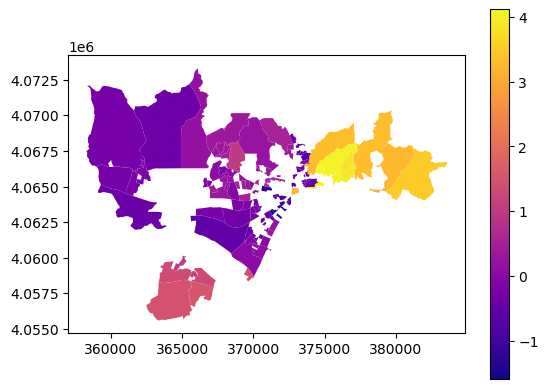

In [59]:
seccion_df_2021_rf.plot(column='SES', cmap="plasma", legend=True)

<Axes: >

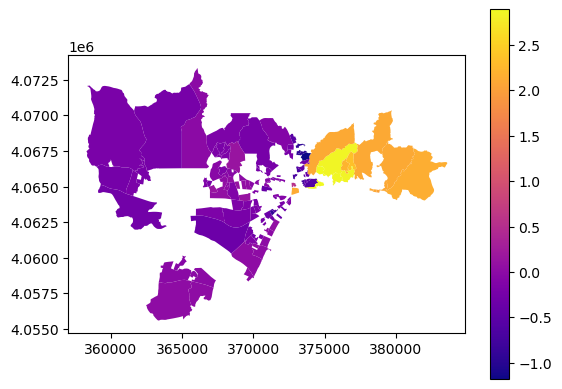

In [61]:
seccion_df_2021_rf.plot(column='Predicted_SES_21', cmap="plasma", legend=True)